In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import os
import sys
import torch
from torch.utils.data import DataLoader, Dataset
from properscoring import crps_ensemble
import random




sys.path.append(os.path.abspath('../src'))
project_dir = Path.cwd().parent

from data_tools.data_utils import SimulateSero, PartialCountDataset, TrueCountDataset
from model_tools.train_utils import BaseTrain, SeroTrain, DirectTrain
from model_tools.models import SimSero, DirectSero
from model_tools.evaluation import eval_sero_pnn, plot_sero_pnn_preds, eval_pnn, eval_direct_sero

start_year = 2016
end_year = 2022
data_split = [5/7, 1/7, 1/7]
seed = 123

D = 40
M = 50
T = 40
Q = 40
N = 4


# 123, 2019, 2023, 15

def set_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True)




In [2]:
# Simulate Data
# True counts * Constant sero prop vec * constant delay vec from average across world samples
p_sero = np.array([0.5, 0.3, 0.2, 0.1])
# p_sero = np.array([0.9, 0.0, 0.05, 0.05])
sero_all = ["DENV-1", "DENV-2", "DENV-3", "DENV-4"]



delays_df = pd.read_csv(project_dir / "data" / "transformed" / "DENG_delays.csv")
delays_df = delays_df.set_index("Collection date")
delays_df.index = pd.to_datetime(delays_df.index)

y_true = delays_df.sum(1)[:-2]
y_true_df = y_true.groupby(y_true.index.to_period("M")).sum()
y_true = np.array(y_true_df)
const = 10*np.ones_like(y_true)

denv_df = pd.read_csv(project_dir / "data" / "transformed" / "denv_df.csv")

denv_df = denv_df[denv_df['Delay'] < 60]

# If your original denv_df dates are datetime
denv_df['Collection date'] = pd.to_datetime(denv_df['Collection date'])

start_month = pd.to_datetime(delays_df.index.min())
end_month = pd.to_datetime(delays_df.index.max())

# Create a DataFrame of month start dates as datetime (not Period)
dates = pd.DataFrame({
    "Collection date": pd.date_range(start=start_month, end=end_month, freq='MS')
})

df = denv_df[denv_df['Sero'] == "DENV-1"] \
    .groupby(['Sero', 'Collection date', 'Delay']) \
    .size() \
    .reset_index(name='count')

df = df.pivot(index='Collection date', columns='Delay', values='count')

# Ensure df.index is datetime as well
df.index = pd.to_datetime(df.index)

p_delay = np.array(df.fillna(0).mean(0) / df.fillna(0).mean(0).sum())

p_sero = p_sero[:, np.newaxis, np.newaxis]   # shape (S,1,1)
const = const[np.newaxis, :, np.newaxis]  # shape (1,T,1)
p_delay = p_delay[np.newaxis, np.newaxis, :Q]  # shape (1,1,D)

# multiply to get (S,T,D)
sero_tensor = p_sero * const * p_delay
# sero_tensor = sero_tensor.round()
for s,sero in enumerate(sero_all):
    sero_df = pd.DataFrame(sero_tensor[s, :, :])
    sero_df.index = y_true_df.index
    sero_df.to_csv(project_dir / "data" / "model" / "sero_dfs" / f"{sero}.csv", index=True)
    print("Saving sero: ", sero)


# Create Serotype obj
sero_tensor = []
base_folder = project_dir / "data" / "model" / "sero_dfs"
files = [f for f in os.listdir(base_folder) if f.endswith('.csv')]
for file in files:
    file_path = os.path.join(base_folder, file)
    df = pd.read_csv(file_path)
    dates = df['Collection date']
    sero_df = df.drop(columns="Collection date")
    sero_tensor.append(sero_df)
sero_tensor = np.array(sero_tensor)

sero_dataset = SimulateSero(sero_tensor, dates, T=T, Q=Q, N=N, prop_vec=p_sero)



# Create count obj
delays_df = pd.read_csv(project_dir / "data" / "transformed" / "DENG_delays.csv")
delays_df['Collection date'] = pd.to_datetime(delays_df['Collection date'])

partial_count_dataset = PartialCountDataset(delays_df, D=D, M=M)
true_count_dataset = TrueCountDataset(delays_df)


# End of 2023 appears to have some incomplete data
if end_year == 2023:
    dates = list(pd.date_range(f"{start_year}-01-01",f"{end_year}-12-25", freq='D'))
else:
    dates = list(pd.date_range(f"{start_year}-01-01",f"{end_year}-12-31", freq='D'))
data_split_sizes = (np.array(data_split) * len(dates)).astype(int)

# Ensure dates line up fully, also removing 2023-12-31 as doesn't appear complete
data_split_sizes[-1] = len(dates) - data_split_sizes[:-1].sum()


train_dates = dates[:data_split_sizes[0]]
val_dates = dates[data_split_sizes[0]:data_split_sizes[0]+data_split_sizes[1]]
test_dates = dates[data_split_sizes[0]+data_split_sizes[1]:]


class SeroPNNDataset(Dataset):
    def __init__(self, partial_count_obj, true_count_obj, sero_obj, dates):
        self.partial_count_obj = partial_count_obj
        self.true_count_obj = true_count_obj
        self.sero_obj = sero_obj
        self.dates = dates
    
    def __len__(self):
        return len(self.dates)
    
    def __getitem__(self, index):
        date = self.dates[index]
        obs = self.partial_count_obj.get_obs(date)
        sero_obs = self.sero_obj.get_obs(date)
        prop_vec = self.sero_obj.get_prop_vec(date)
        y = self.true_count_obj.get_y_prop(date, prop_vec)
        dow = date.day_of_week
        return (obs, dow, sero_obs), y
    
set_seed(seed)
sero_props = pd.read_csv(project_dir / "data" / "transformed" / "sero_props.csv")


train_sero_pnn_dataset = SeroPNNDataset(partial_count_dataset, true_count_dataset, sero_dataset, train_dates)
val_sero_pnn_dataset = SeroPNNDataset(partial_count_dataset, true_count_dataset, sero_dataset, val_dates)
test_sero_pnn_dataset = SeroPNNDataset(partial_count_dataset, true_count_dataset,  sero_dataset, test_dates)

g = torch.Generator()
g.manual_seed(seed)

train_loader = DataLoader(train_sero_pnn_dataset, batch_size=32, shuffle=True, generator=g)
val_loader = DataLoader(val_sero_pnn_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_sero_pnn_dataset, batch_size=32, shuffle=False)


Saving sero:  DENV-1
Saving sero:  DENV-2
Saving sero:  DENV-3
Saving sero:  DENV-4


In [3]:
N = len(sero_dataset.get_prop_vec("2020-01-01"))
sero_pnn_model = SimSero(M=M, D=D, T=T, Q=Q, N=N, hidden_units = [16, 8], conv_channels = [16, 1], embedding_dim = 10, dropout_probs = [0.15, 0.1], device="cpu")
sero_pnn_train = SeroTrain("SeroPNN", lr=0.0003)
sero_pnn_train.train_model(sero_pnn_model, train_loader, val_loader)



Epoch 1 - Train loss: 2.1e+03 - Val loss: 2.48e+04 - ES count: 0
Epoch 2 - Train loss: 1.8e+03 - Val loss: 2.04e+04 - ES count: 0
Epoch 3 - Train loss: 1.66e+03 - Val loss: 1.85e+04 - ES count: 0
Epoch 4 - Train loss: 1.53e+03 - Val loss: 1.64e+04 - ES count: 0
Epoch 5 - Train loss: 1.41e+03 - Val loss: 1.44e+04 - ES count: 0
Epoch 6 - Train loss: 1.28e+03 - Val loss: 1.21e+04 - ES count: 0
Epoch 7 - Train loss: 1.18e+03 - Val loss: 1.14e+04 - ES count: 0
Epoch 8 - Train loss: 1.06e+03 - Val loss: 9.14e+03 - ES count: 0
Epoch 9 - Train loss: 9.59e+02 - Val loss: 1.06e+04 - ES count: 1
Epoch 10 - Train loss: 8.49e+02 - Val loss: 8.17e+03 - ES count: 0
Epoch 11 - Train loss: 7.5e+02 - Val loss: 7.77e+03 - ES count: 0
Epoch 12 - Train loss: 6.37e+02 - Val loss: 6.09e+03 - ES count: 0
Epoch 13 - Train loss: 5.78e+02 - Val loss: 5.31e+03 - ES count: 0
Epoch 14 - Train loss: 4.85e+02 - Val loss: 4.33e+03 - ES count: 0
Epoch 15 - Train loss: 4.07e+02 - Val loss: 3.23e+03 - ES count: 0
Epoch 1

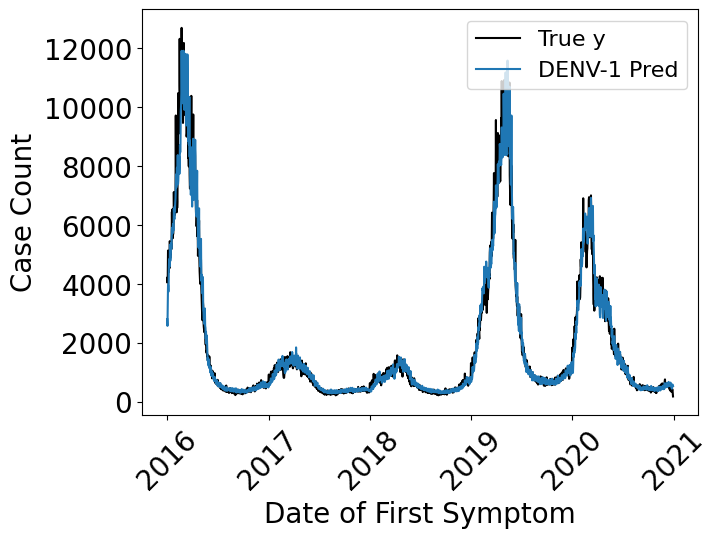

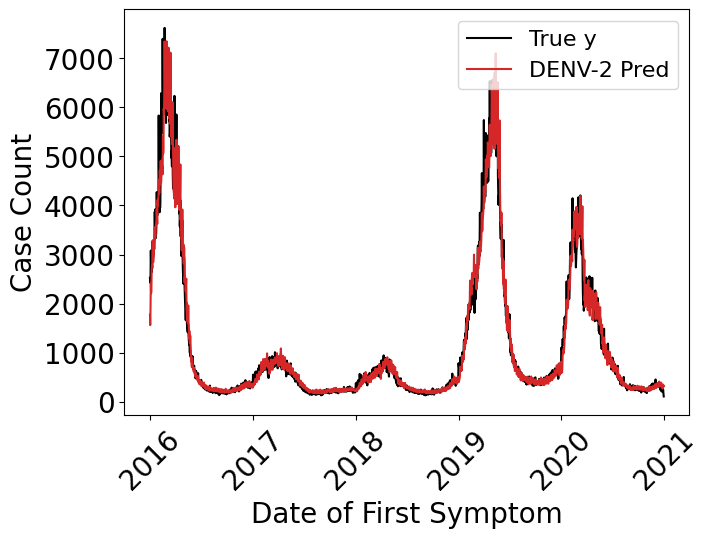

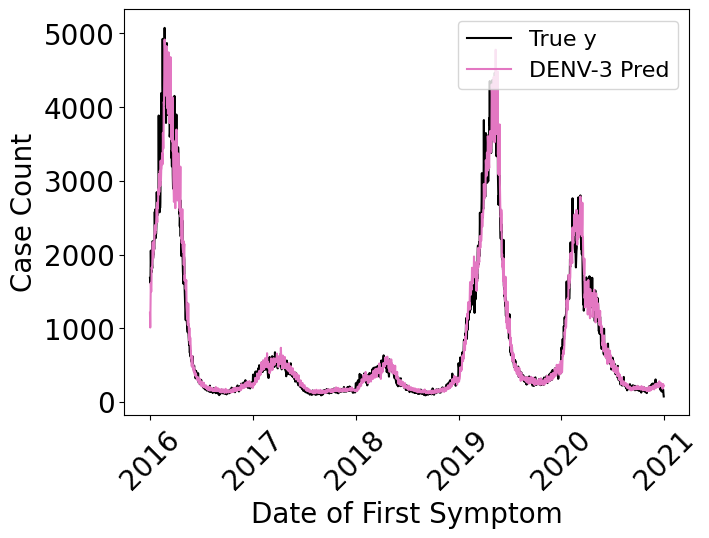

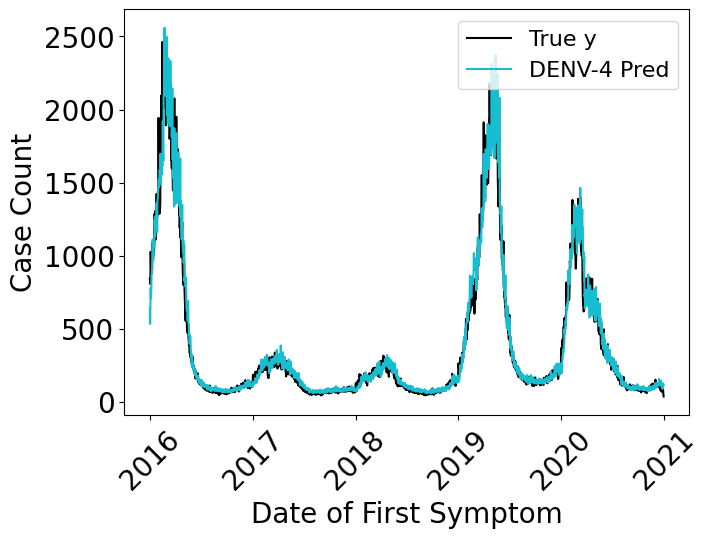

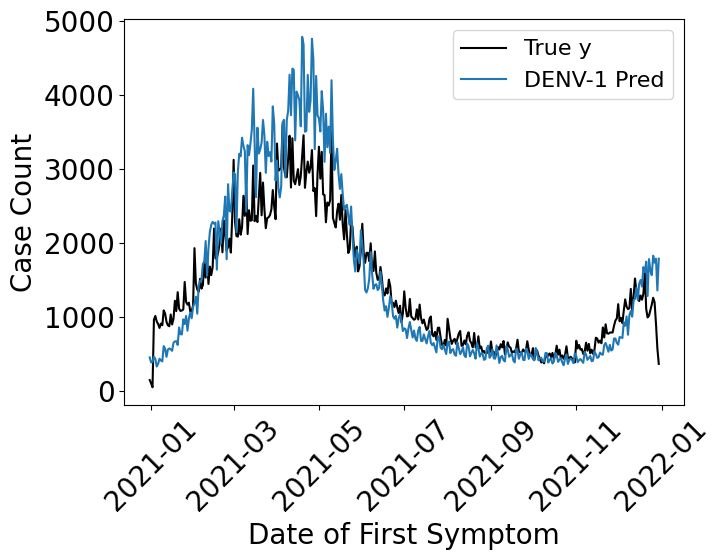

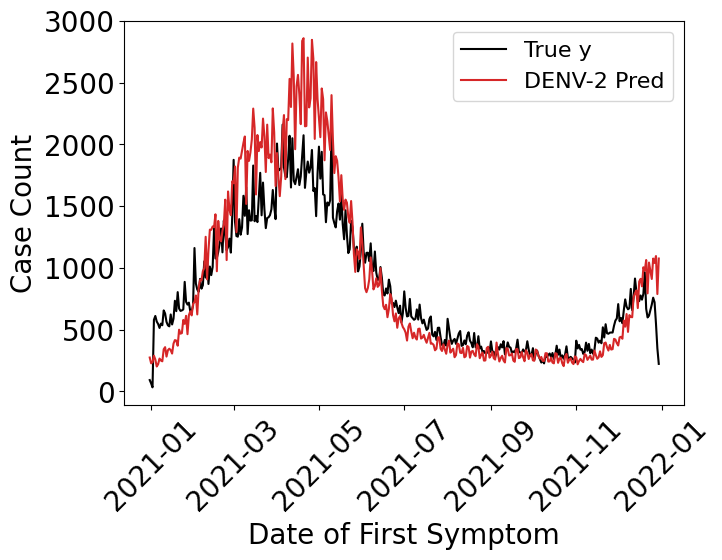

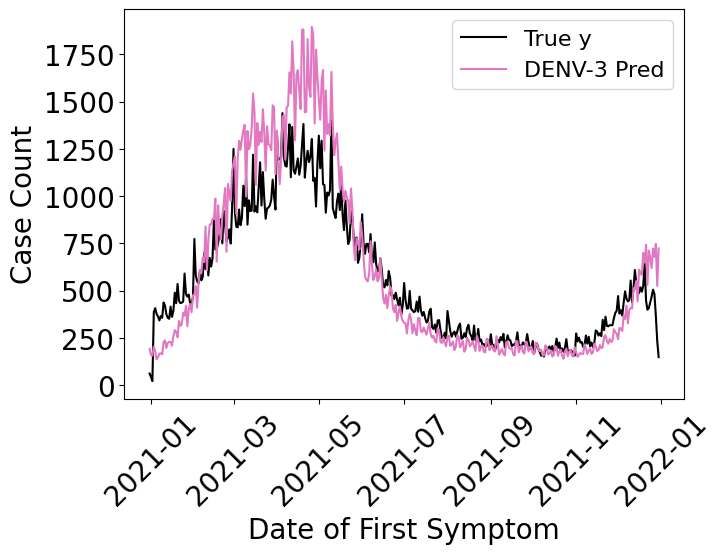

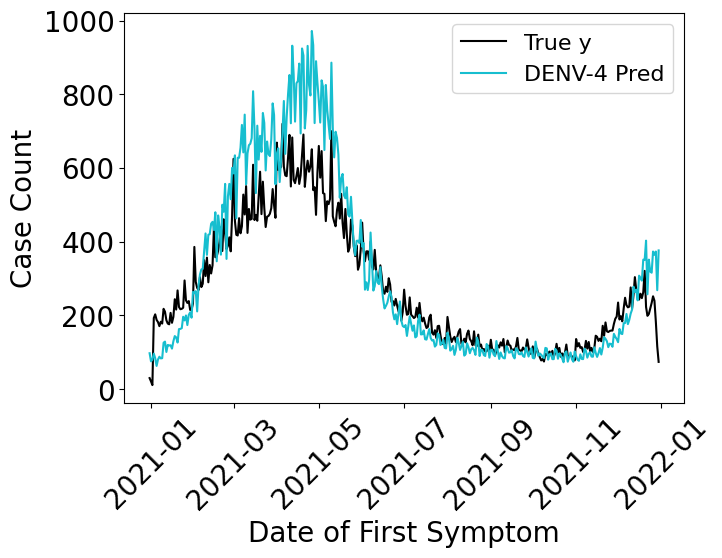

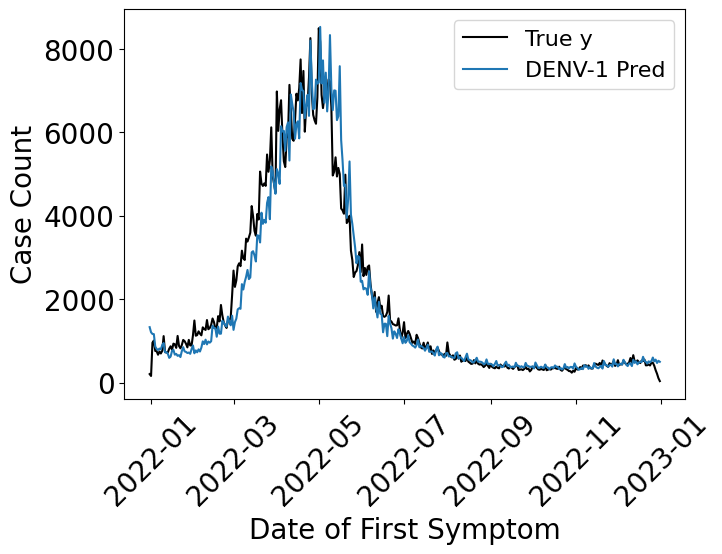

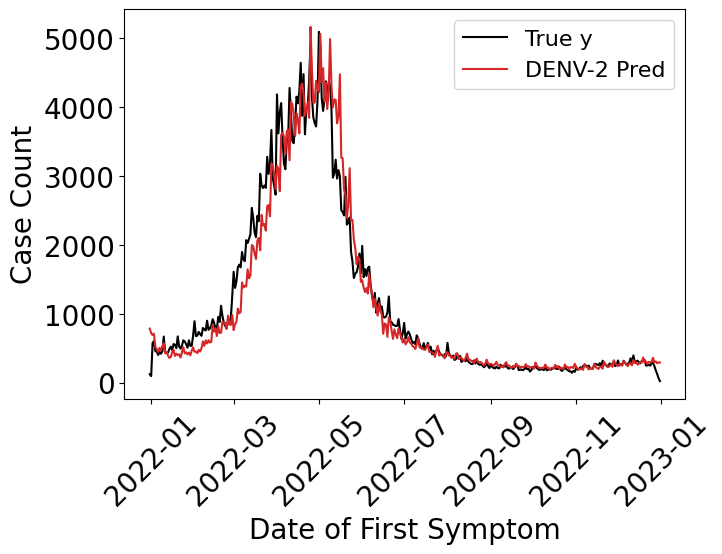

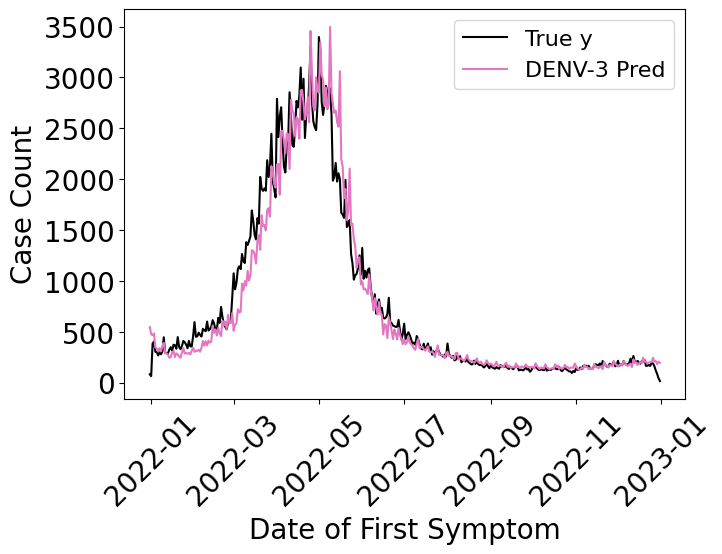

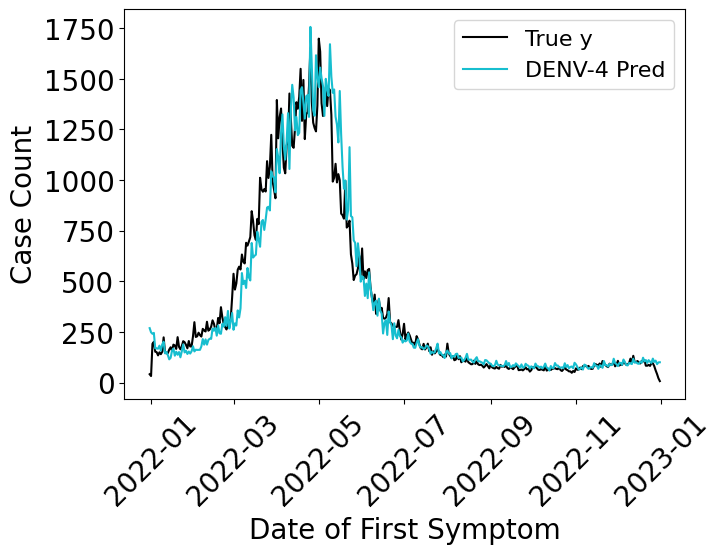

In [4]:
base_save_path = project_dir / "src" / "outputs" / "visuals" / "serotype-nowcasts" / "raw" / "const-props"
N = len(sero_dataset.get_prop_vec("2020-01-01"))
sero_pnn_model = SimSero(M=M, D=D, T=T, Q=Q, N=N, hidden_units = [16, 8], conv_channels = [16, 1], embedding_dim = 10, dropout_probs = [0.15, 0.1], device="cpu")
sero_pnn_model.load_state_dict(torch.load(project_dir /"src" / "outputs" / "weights" / f"weights-SeroPNN"))

sero_pnn_train_samples, train_y_true = eval_sero_pnn(train_sero_pnn_dataset, sero_pnn_model, N=N)
plot_sero_pnn_preds(sero_pnn_train_samples, train_sero_pnn_dataset, N)

# crps = 0
# crps = sum([crps_ensemble(train_y_true[:,s], sero_pnn_train_samples[:,s,:]).mean() for s in range(N)])
# print(f"CRPS: {crps}")
sero_pnn_val_samples, val_y_true = eval_sero_pnn(val_sero_pnn_dataset, sero_pnn_model, N=N)
plot_sero_pnn_preds(sero_pnn_val_samples, val_sero_pnn_dataset, N)

# crps = 0
# crps = sum([crps_ensemble(val_y_true[:,s], sero_pnn_val_samples[:,s,:]).mean() for s in range(N)])
# print(f"CRPS: {crps}")
sero_pnn_test_samples, test_y_true = eval_sero_pnn(test_sero_pnn_dataset, sero_pnn_model, N=N)
plot_sero_pnn_preds(sero_pnn_test_samples, test_sero_pnn_dataset, N,  base_save_path)

# crps = 0
# crps = sum([crps_ensemble(test_y_true[:,s,:,0], sero_pnn_test_samples[:,s,:]) for s in range(N)])
# print(f"CRPS: {crps}")

In [5]:
# Simulate Data
# True counts * Constant sero prop vec * constant delay vec from average across world samples
# p_sero = np.array([0.5, 0.3, 0.2, 0.1])
p_sero = np.array([0.9, 0.0, 0.05, 0.05])
sero_all = ["DENV-1", "DENV-2", "DENV-3", "DENV-4"]



delays_df = pd.read_csv(project_dir / "data" / "transformed" / "DENG_delays.csv")
delays_df = delays_df.set_index("Collection date")
delays_df.index = pd.to_datetime(delays_df.index)

y_true = delays_df.sum(1)[:-2]
y_true_df = y_true.groupby(y_true.index.to_period("M")).sum()
y_true = np.array(y_true_df)
const = 10*np.ones_like(y_true)

denv_df = pd.read_csv(project_dir / "data" / "transformed" / "denv_df.csv")

denv_df = denv_df[denv_df['Delay'] < 60]

# If your original denv_df dates are datetime
denv_df['Collection date'] = pd.to_datetime(denv_df['Collection date'])

start_month = pd.to_datetime(delays_df.index.min())
end_month = pd.to_datetime(delays_df.index.max())

# Create a DataFrame of month start dates as datetime (not Period)
dates = pd.DataFrame({
    "Collection date": pd.date_range(start=start_month, end=end_month, freq='MS')
})

df = denv_df[denv_df['Sero'] == "DENV-1"] \
    .groupby(['Sero', 'Collection date', 'Delay']) \
    .size() \
    .reset_index(name='count')

df = df.pivot(index='Collection date', columns='Delay', values='count')

# Ensure df.index is datetime as well
df.index = pd.to_datetime(df.index)

p_delay = np.array(df.fillna(0).mean(0) / df.fillna(0).mean(0).sum())

p_sero = p_sero[:, np.newaxis, np.newaxis]   # shape (S,1,1)
const = const[np.newaxis, :, np.newaxis]  # shape (1,T,1)
p_delay = p_delay[np.newaxis, np.newaxis, :Q]  # shape (1,1,D)

# multiply to get (S,T,D)
sero_tensor = p_sero * const * p_delay
# sero_tensor = sero_tensor.round()
for s,sero in enumerate(sero_all):
    sero_df = pd.DataFrame(sero_tensor[s, :, :])
    sero_df.index = y_true_df.index
    sero_df.to_csv(project_dir / "data" / "model" / "sero_dfs" / f"{sero}.csv", index=True)
    print("Saving sero: ", sero)


# Create Serotype obj
sero_tensor = []
base_folder = project_dir / "data" / "model" / "sero_dfs"
files = [f for f in os.listdir(base_folder) if f.endswith('.csv')]
for file in files:
    file_path = os.path.join(base_folder, file)
    df = pd.read_csv(file_path)
    dates = df['Collection date']
    sero_df = df.drop(columns="Collection date")
    sero_tensor.append(sero_df)
sero_tensor = np.array(sero_tensor)

sero_dataset = SimulateSero(sero_tensor, dates, T=T, Q=Q, N=N, prop_vec=p_sero)



# Create count obj
delays_df = pd.read_csv(project_dir / "data" / "transformed" / "DENG_delays.csv")
delays_df['Collection date'] = pd.to_datetime(delays_df['Collection date'])

partial_count_dataset = PartialCountDataset(delays_df, D=D, M=M)
true_count_dataset = TrueCountDataset(delays_df)


# End of 2023 appears to have some incomplete data
if end_year == 2023:
    dates = list(pd.date_range(f"{start_year}-01-01",f"{end_year}-12-25", freq='D'))
else:
    dates = list(pd.date_range(f"{start_year}-01-01",f"{end_year}-12-31", freq='D'))
data_split_sizes = (np.array(data_split) * len(dates)).astype(int)

# Ensure dates line up fully, also removing 2023-12-31 as doesn't appear complete
data_split_sizes[-1] = len(dates) - data_split_sizes[:-1].sum()


train_dates = dates[:data_split_sizes[0]]
val_dates = dates[data_split_sizes[0]:data_split_sizes[0]+data_split_sizes[1]]
test_dates = dates[data_split_sizes[0]+data_split_sizes[1]:]


class SeroPNNDataset(Dataset):
    def __init__(self, partial_count_obj, true_count_obj, sero_obj, dates):
        self.partial_count_obj = partial_count_obj
        self.true_count_obj = true_count_obj
        self.sero_obj = sero_obj
        self.dates = dates
    
    def __len__(self):
        return len(self.dates)
    
    def __getitem__(self, index):
        date = self.dates[index]
        obs = self.partial_count_obj.get_obs(date)
        sero_obs = self.sero_obj.get_obs(date)
        prop_vec = self.sero_obj.get_prop_vec(date)
        y = self.true_count_obj.get_y_prop(date, prop_vec)
        dow = date.day_of_week
        return (obs, dow, sero_obs), y
    
set_seed(seed)
sero_props = pd.read_csv(project_dir / "data" / "transformed" / "sero_props.csv")


train_sero_pnn_dataset = SeroPNNDataset(partial_count_dataset, true_count_dataset, sero_dataset, train_dates)
val_sero_pnn_dataset = SeroPNNDataset(partial_count_dataset, true_count_dataset, sero_dataset, val_dates)
test_sero_pnn_dataset = SeroPNNDataset(partial_count_dataset, true_count_dataset,  sero_dataset, test_dates)

g = torch.Generator()
g.manual_seed(seed)

train_loader = DataLoader(train_sero_pnn_dataset, batch_size=32, shuffle=True, generator=g)
val_loader = DataLoader(val_sero_pnn_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_sero_pnn_dataset, batch_size=32, shuffle=False)


Saving sero:  DENV-1
Saving sero:  DENV-2
Saving sero:  DENV-3
Saving sero:  DENV-4


In [6]:
N = len(sero_dataset.get_prop_vec("2020-01-01"))
sero_pnn_model = SimSero(M=M, D=D, T=T, Q=Q, N=N, hidden_units = [16, 8], conv_channels = [16, 1], embedding_dim = 10, dropout_probs = [0.15, 0.1], device="cpu")
sero_pnn_train = SeroTrain("SeroPNN(low const)", lr=0.0003, num_epochs=300)
sero_pnn_train.train_model(sero_pnn_model, train_loader, val_loader)



Epoch 1 - Train loss: 2.85e+03 - Val loss: 4.16e+04 - ES count: 0
Epoch 2 - Train loss: 2.57e+03 - Val loss: 2.43e+04 - ES count: 0
Epoch 3 - Train loss: 2.28e+03 - Val loss: 2.54e+04 - ES count: 1
Epoch 4 - Train loss: 2.04e+03 - Val loss: 2.23e+04 - ES count: 0
Epoch 5 - Train loss: 1.9e+03 - Val loss: 1.81e+04 - ES count: 0
Epoch 6 - Train loss: 1.73e+03 - Val loss: 1.64e+04 - ES count: 0
Epoch 7 - Train loss: 1.72e+03 - Val loss: 1.81e+04 - ES count: 1
Epoch 8 - Train loss: 1.51e+03 - Val loss: 1.4e+04 - ES count: 0
Epoch 9 - Train loss: 1.33e+03 - Val loss: 1.31e+04 - ES count: 0
Epoch 10 - Train loss: 1.3e+03 - Val loss: 1.43e+04 - ES count: 1
Epoch 11 - Train loss: 1.35e+03 - Val loss: 1.4e+04 - ES count: 2
Epoch 12 - Train loss: 1.19e+03 - Val loss: 1.14e+04 - ES count: 0
Epoch 13 - Train loss: 1.06e+03 - Val loss: 1.03e+04 - ES count: 0
Epoch 14 - Train loss: 9.57e+02 - Val loss: 9.41e+03 - ES count: 0
Epoch 15 - Train loss: 8.48e+02 - Val loss: 7.58e+03 - ES count: 0
Epoch 16

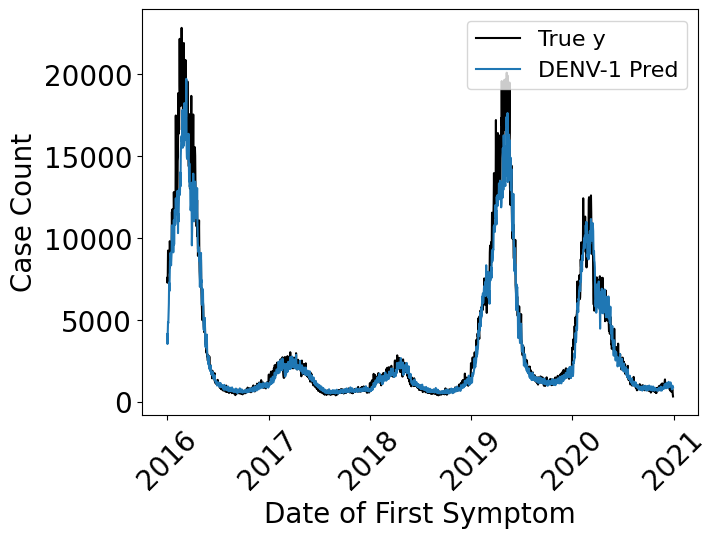

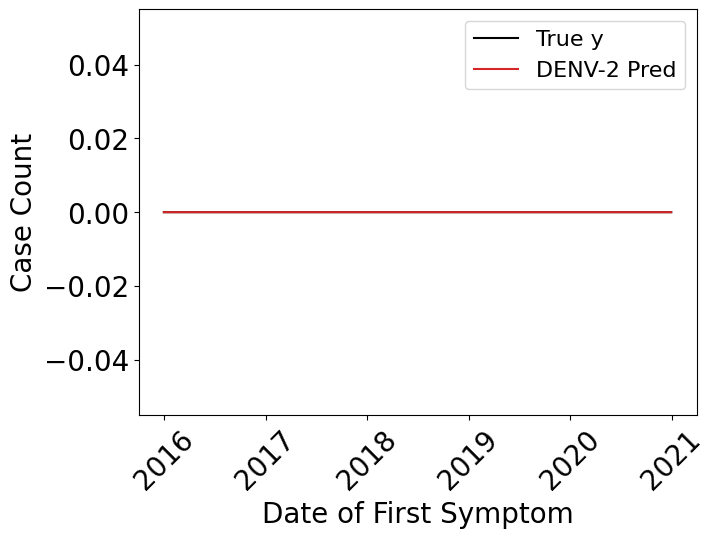

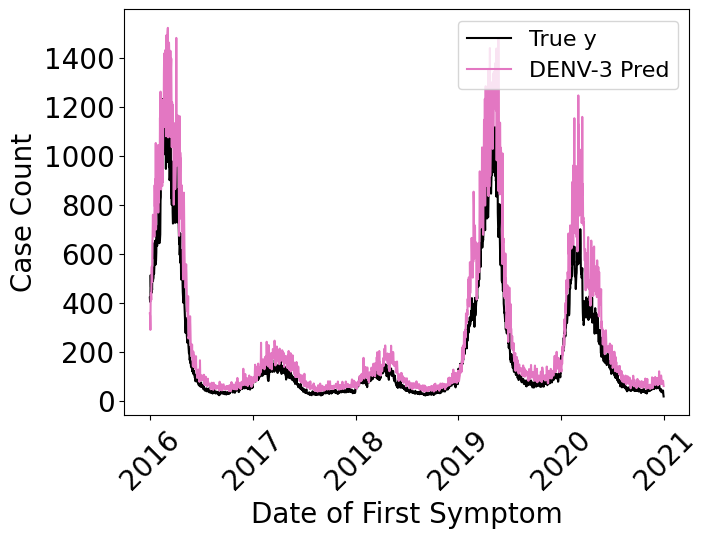

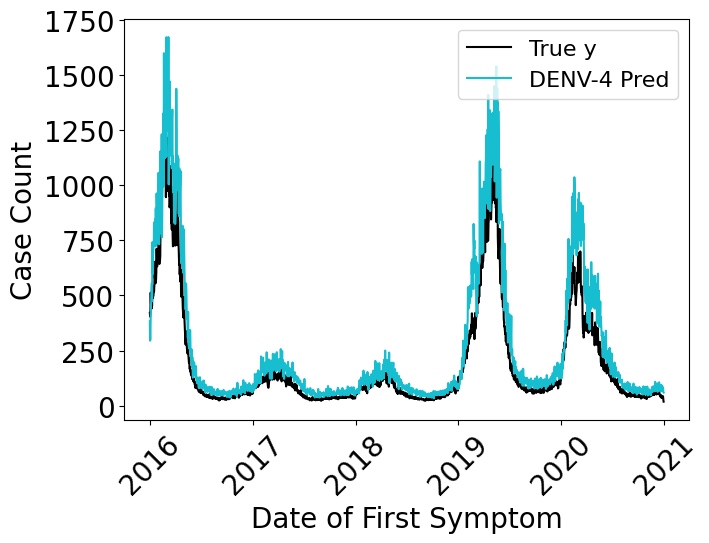

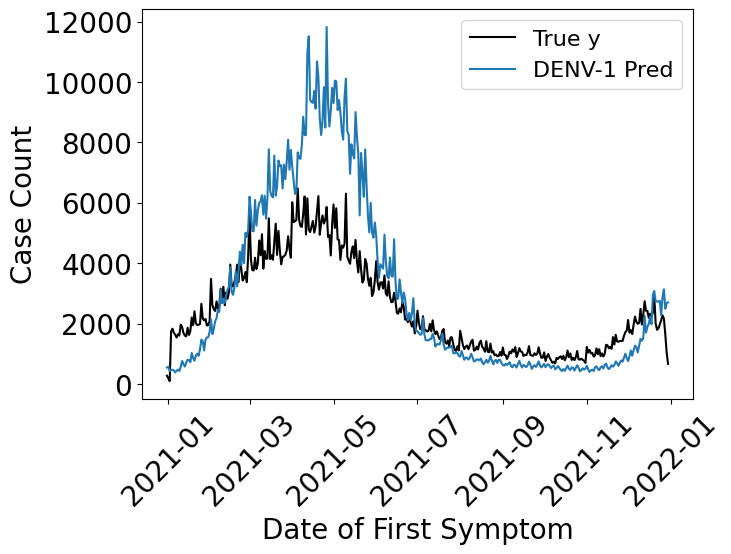

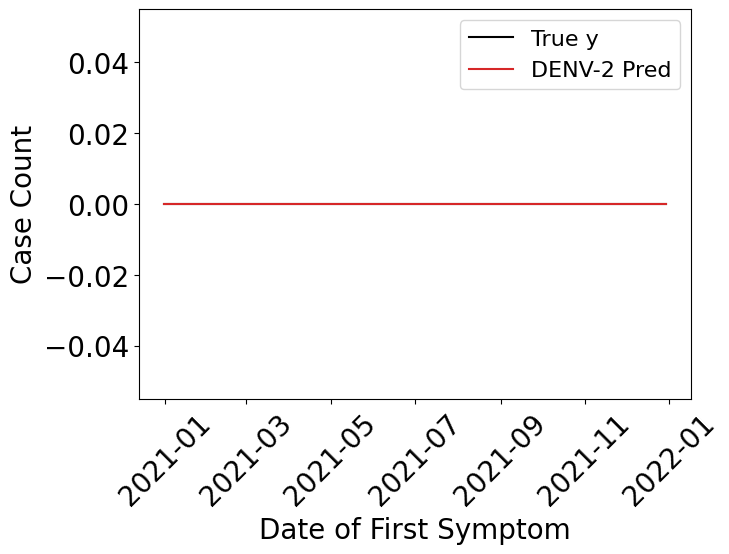

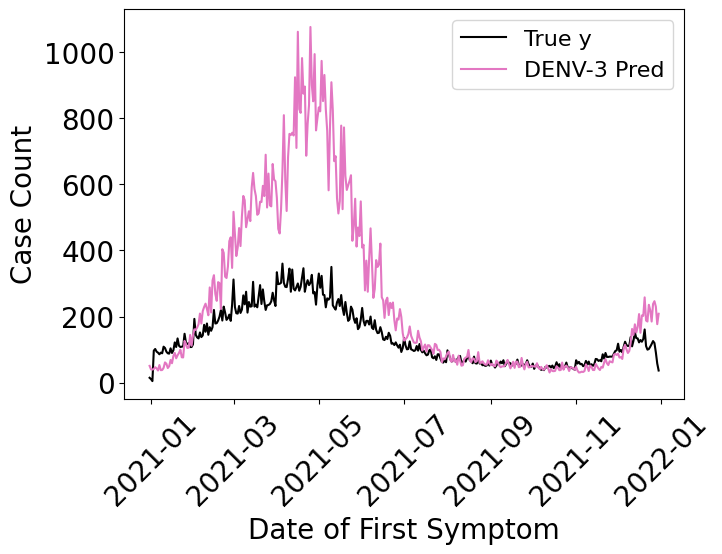

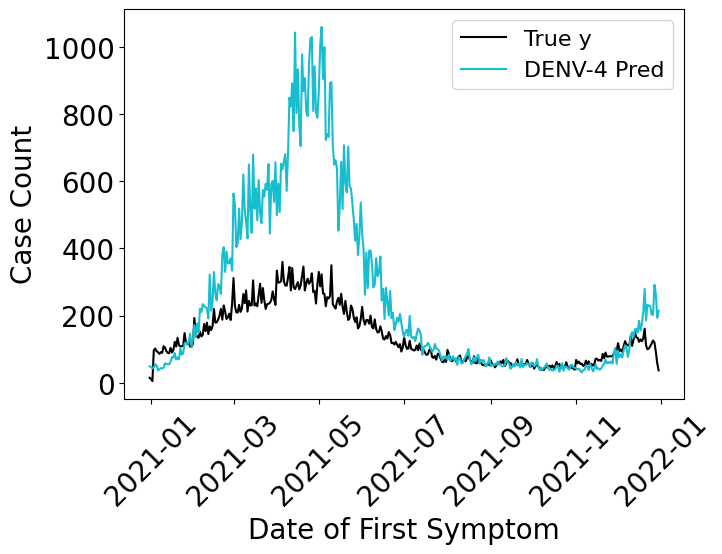

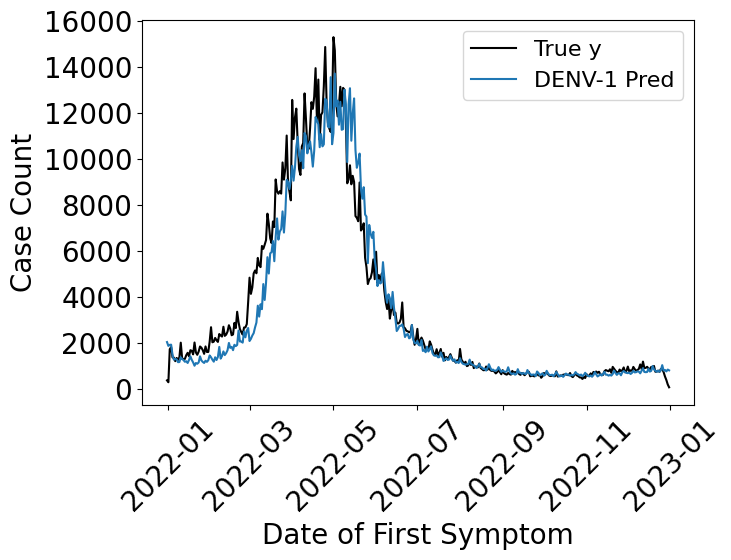

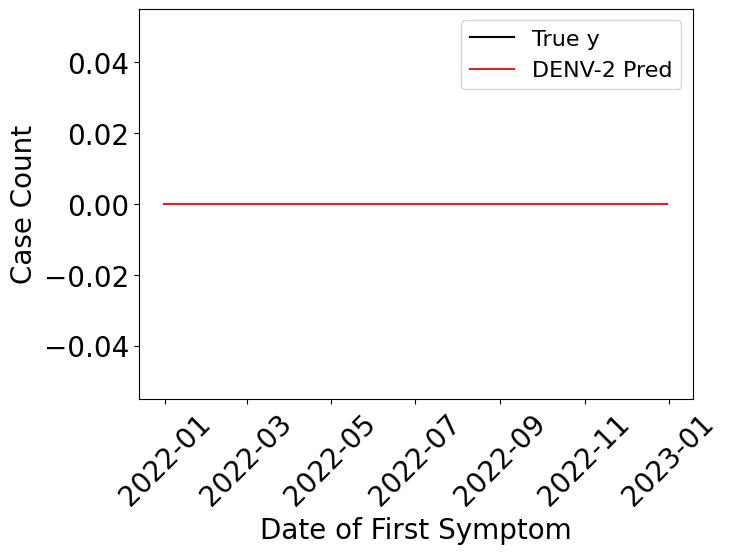

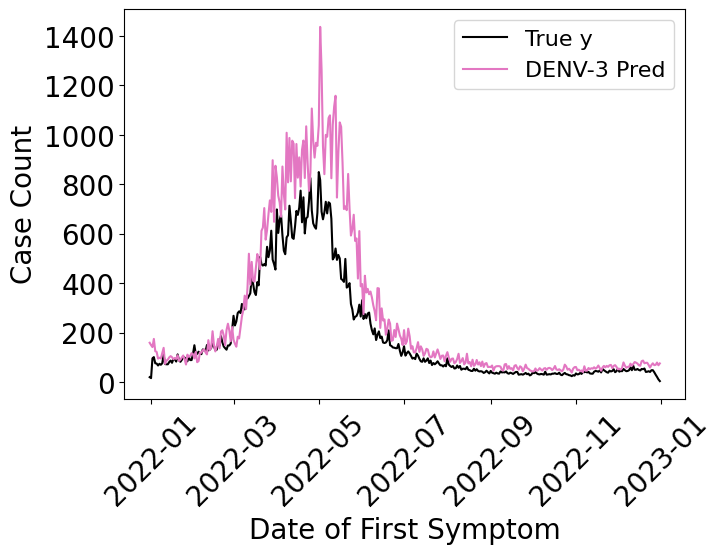

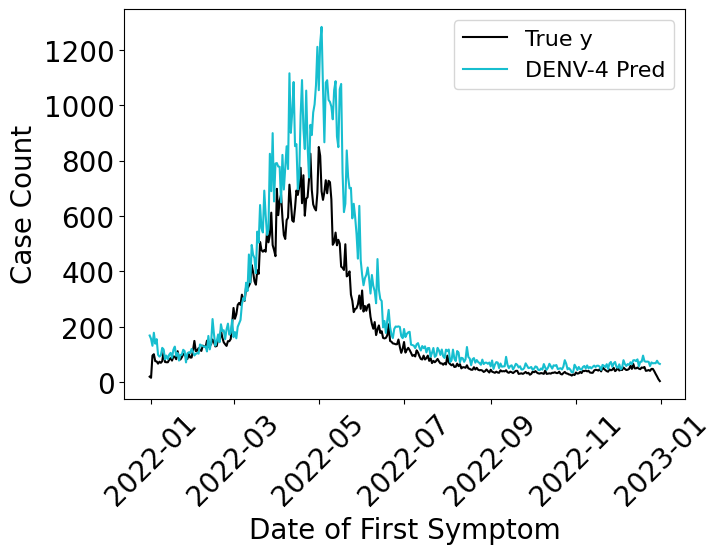

In [7]:
base_save_path = project_dir / "src" / "outputs" / "visuals" / "serotype-nowcasts" / "raw" / "low-const-props"

N = len(sero_dataset.get_prop_vec("2020-01-01"))
sero_pnn_model = SimSero(M=M, D=D, T=T, Q=Q, N=N, hidden_units = [16, 8], conv_channels = [16, 1], embedding_dim = 10, dropout_probs = [0.15, 0.1], device="cpu")
sero_pnn_model.load_state_dict(torch.load(project_dir /"src" / "outputs" / "weights" / f"weights-SeroPNN(low const)"))

sero_pnn_train_samples, train_y_true = eval_sero_pnn(train_sero_pnn_dataset, sero_pnn_model, N=N)
plot_sero_pnn_preds(sero_pnn_train_samples, train_sero_pnn_dataset, N)

# crps = 0
# crps = sum([crps_ensemble(train_y_true[:,s], sero_pnn_train_samples[:,s,:]).mean() for s in range(N)])
# print(f"CRPS: {crps}")
sero_pnn_val_samples, val_y_true = eval_sero_pnn(val_sero_pnn_dataset, sero_pnn_model, N=N)
plot_sero_pnn_preds(sero_pnn_val_samples, val_sero_pnn_dataset, N)

# crps = 0
# crps = sum([crps_ensemble(val_y_true[:,s], sero_pnn_val_samples[:,s,:]).mean() for s in range(N)])
# print(f"CRPS: {crps}")
sero_pnn_test_samples, test_y_true = eval_sero_pnn(test_sero_pnn_dataset, sero_pnn_model, N=N)
plot_sero_pnn_preds(sero_pnn_test_samples, test_sero_pnn_dataset, N, base_save_path)

# crps = 0
# crps = sum([crps_ensemble(test_y_true[:,s,:,0], sero_pnn_test_samples[:,s,:]) for s in range(N)])
# print(f"CRPS: {crps}")